In [2]:
from pathlib import Path
import sys
sys.path.append("E:/Betting/CSGO/Test")

import pandas as pd
import numpy as np
import sys
from resources import feature_moments
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, brier_score_loss, log_loss
from sklearn.model_selection import KFold

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### TODO
1. Format dataset to be compatible with ml
    - devise strategy for renaming winner / loser columns 
    - remove 1500 & 350 rd for both team ratings
    - look into and handle null or bad data processing
2. EDA & Feature engineering
    - Look at old valorant features
    - GPT and brainstorm additional features
    - Normal dist win prob, raw difference, % difference, etc?
3. Feature importance analysis
4. Cross validation
    - Fit several models and get their cv metrics
    - Scale data within folds if needed
    - Determine best model
5. Backtest on collected odds
    - Remember to convert map odds to match odds (how do i do this?)
    - Simulate odd compression after limit betting once
    - Could use odds (t) to estimate this behaviour
6. Create script using pinny api to get new lines / bet lines when they are priced good 
    - Think about all conditions that could happen
        - What to do with new players / missing some players data (Fill with 'average' player?)
    - Practical max bets based on function off length of odds (higher bet limits for short odds) (BE prob ie 1/odds multiplied by max bet for 1.01 odds)
7. Create production interface/webapp on server
    - Auto run data collection scripts periodically
    - Constantly crawl pinny api for potential bets
    - Store data about taken bets and line data (lines i got vs lines odds are at / closing at)


In [ ]:
raw_game_data = pd.read_csv("../datasets/games_stats.csv")

In [33]:
def transform_dataframe(df):
    # Split the DataFrame into two equal parts
    df1 = df.copy()
    df2 = df.copy()

    # Rename 'winner' to 'home' and 'loser' to 'away' in the first half
    df1.columns = [col.replace('winner_team_', 'A_').replace('loser_team_', 'B_').replace('winner_', 'A_').replace('loser_', 'B_') for col in df1.columns]

    # Rename 'winner' to 'away' and 'loser' to 'home' in the second half
    df2.columns = [col.replace('winner_team_', 'B_').replace('loser_team_', 'A_').replace('winner_', 'B_').replace('loser_', 'A_') for col in df2.columns]

    df1['A_win'] = df1.apply(lambda x: 1 if x['A_score'] > x['B_score'] else 0, axis=1)
    df2['A_win'] = df2.apply(lambda x: 1 if x['A_score'] > x['B_score'] else 0, axis=1)

    # Concatenate the two DataFrames
    transformed_df = pd.concat([df1, df2], ignore_index=True)

    # Shuffle the DataFrame rows if you want to mix the home and away perspectives
    transformed_df = transformed_df.sample(frac=1).reset_index(drop=True)

    return transformed_df

In [34]:
transformed_game_data = transform_dataframe(raw_game_data) #Make data able to be classified by ML

In [35]:
transformed_game_data = transformed_game_data.dropna(subset=['A_score'])
transformed_game_data = transformed_game_data.dropna(subset=['B_score'])
transformed_game_data = transformed_game_data.dropna(subset=['status'])
transformed_game_data = transformed_game_data.dropna(subset=['A_rating'])
transformed_game_data = transformed_game_data.dropna(subset=['B_rating'])
transformed_game_data = transformed_game_data.dropna(subset=['rounds_count'])
transformed_game_data = transformed_game_data.dropna(subset=['A_5_kpr'])
transformed_game_data = transformed_game_data.dropna(subset=['B_5_kpr'])
if 'B_glicko_win_prob' in transformed_game_data.columns:
    transformed_game_data.loc[transformed_game_data['A_glicko_win_prob'].isnull(), 'A_glicko_win_prob'] = 1 - transformed_game_data['B_glicko_win_prob']
    transformed_game_data.drop('B_glicko_win_prob', axis=1, inplace=True)



#transformed_game_data[transformed_game_data['rounds_count'].isnull()]

In [36]:
A_columns = [col for col in transformed_game_data.columns if "B_" not in col and col not in ['id', 'match_id', 'begin_at', 'map_name', 'duration', 'A_score', 'B_score', 'status', 'number', 'rounds_count', 'A_id', 'B_id', 'A_rating', 'A_deviation', 'A_glicko_win_prob', 'A_win']]

In [37]:
feature_df = transformed_game_data.copy()

delta_columns = {}
ratio_columns = {}
percent_diff_columns = {}
z_score_columns = {}
win_prob_columns = {}
OD_columns = {}
DO_columns = {}

for A_col in A_columns:
    B_col = A_col.replace('A_', 'B_')
    delta_col = A_col.replace('A_', 'delta_')
    ratio_col = A_col.replace('A_', 'ratio_')
    percent_diff_col = A_col.replace('A_', 'percent_diff_')
    z_col = A_col.replace('A_', 'z_')
    win_prob_col = A_col.replace('A_', 'win_prob_')
    mean_name = "_".join(A_col.split('_')[2:]) + '_mean'
    var_name = "_".join(A_col.split('_')[2:]) + '_var'

    # Calculate delta 
    delta_columns[delta_col] = feature_df[A_col] - feature_df[B_col]

    #ratio columns
    ratio_columns[ratio_col] = feature_df[A_col] / feature_df[B_col] 

    #percent diff
    percent_diff_columns[percent_diff_col] = (feature_df[A_col] - feature_df[B_col]) / ((feature_df[A_col] + feature_df[B_col]) / 2)

    #z score
    z_score_columns[z_col] = (feature_df[A_col] - feature_df[B_col]) / np.sqrt(getattr(feature_moments, var_name))

    #Prob
    win_prob_columns[win_prob_col] = norm.cdf((feature_df[A_col] - feature_df[B_col]) / np.sqrt(getattr(feature_moments, var_name)))

    #OD
    if "_T" in A_col:
        B_col_t = A_col.replace("A_", 'B_').replace("_T", "_CT")
        od_col = A_col.replace("A_", "OD_").replace("_T", "")
        OD_columns[od_col] = feature_df[A_col] / feature_df[B_col_t]

    #DO
    if "_CT" in A_col:
        B_col_ct = A_col.replace("A_", 'B_').replace("_CT", "_T")
        do_col = A_col.replace("A_", "DO_").replace("_CT", "")
        DO_columns[do_col] = feature_df[A_col] / feature_df[B_col_ct]

for A_col in A_columns:
    #Drop raw columns   
    B_col = A_col.replace('A_', 'B_')
    feature_df.drop([A_col, B_col], axis=1, inplace=True)
    

# Now concatenate all at once
feature_df = pd.concat([feature_df, pd.DataFrame(delta_columns)], axis=1)
feature_df = pd.concat([feature_df, pd.DataFrame(ratio_columns)], axis=1)
feature_df = pd.concat([feature_df, pd.DataFrame(percent_diff_columns)], axis=1)
feature_df = pd.concat([feature_df, pd.DataFrame(z_score_columns)], axis=1)
feature_df = pd.concat([feature_df, pd.DataFrame(win_prob_columns)], axis=1)
feature_df = pd.concat([feature_df, pd.DataFrame(OD_columns)], axis=1)
feature_df = pd.concat([feature_df, pd.DataFrame(DO_columns)], axis=1)


In [38]:
feature_df.to_csv("../datasets/games_clean_features.csv")

In [3]:
feature_df = pd.read_csv("../datasets/games_clean_features.csv")
feature_df = feature_df.drop(columns=['Unnamed: 0'])

C:\Users\Liam\AppData\Local\Temp\ipykernel_20916\3752253186.py:1: DtypeWarning: Columns (3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  feature_df = pd.read_csv("../datasets/games_clean_features.csv")


In [4]:
# Separate features and target variable
feature_df = feature_df.drop(['id', 'match_id', 'begin_at', 'map_name', 'duration', 'A_score', 'B_score', 'status', 'number', 'rounds_count', 'A_id', 'B_id'], axis=1)
print(len(feature_df.index))
feature_df = feature_df.dropna()
print(len(feature_df.index))

83333
79695


In [5]:
# Separate the features and target variable
X = feature_df.drop(columns=['A_win'])  # Features
y = feature_df['A_win']  # Target variable

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X, y)

feature_importances = rf.feature_importances_
importances = pd.Series(feature_importances, index=X.columns)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

In [ ]:
print(sorted_importances.head(50))

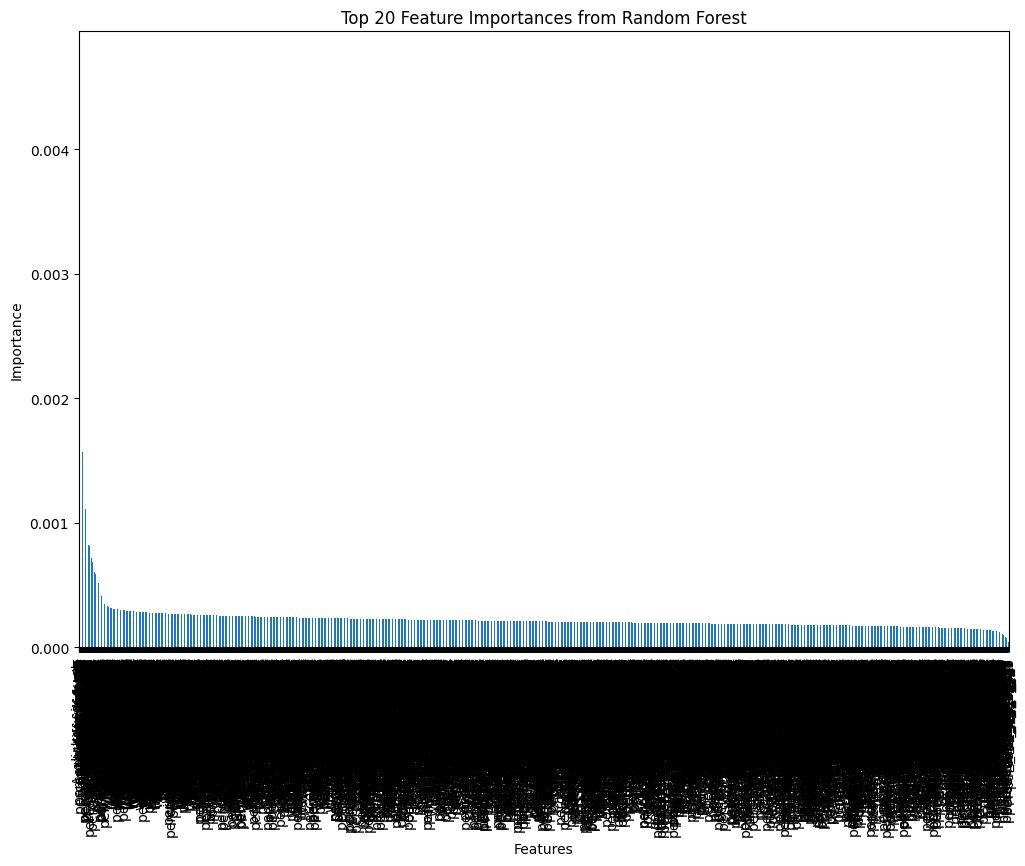

In [12]:


plt.figure(figsize=(12,8))

sorted_importances.plot(kind='bar')

plt.title('Top Feature Importances from Random Forest')

plt.xlabel('Features')

plt.ylabel('Importance')

plt.xticks(rotation=90)

plt.show()

In [15]:
# Since we want to filter out similar features, we will create a function that checks the prefixes of features
# and only keeps the highest importance feature from each group.

def filter_similar_features(importances):
    # Dictionary to keep the highest importance feature of each group
    filtered_importances = {}
    
    # Iterate over the importances
    for feature, importance in importances.items():
        # Check if the feature belongs to one of the groups with similar features
        for prefix in ('percent_diff_', 'win_prob_', 'z_', 'ratio_', 'delta_'):
            if feature.startswith(prefix):
                # Extract the base feature name by removing the prefix
                base_feature = feature[len(prefix):]
                
                # If this base feature is already in our filtered list, update only if the current feature is more important
                if base_feature in filtered_importances:
                    if importance > filtered_importances[base_feature][1]:
                        filtered_importances[base_feature] = (feature, importance)
                else:
                    filtered_importances[base_feature] = (feature, importance)
                break
        else:
            # If the feature does not start with one of the prefixes, add it to the list
            filtered_importances[feature] = (feature, importance)
    
    # Sort the filtered features by importance
    sorted_filtered_importances = sorted(filtered_importances.values(), key=lambda x: x[1], reverse=True)
    
    return sorted_filtered_importances

# Apply the filter function to the importances
unique_importances = filter_similar_features(importances)

# Display the filtered unique features
print(len(importances))
print(len(unique_importances))
unique_importances[:10]


4359
1279


[('A_glicko_win_prob', 0.004709043452042811),
 ('percent_diff_inf_rwpr', 0.0025718348542362783),
 ('z_inf_kdr_CT', 0.0024198726006454947),
 ('z_inf_tdp', 0.002229666993072546),
 ('percent_diff_inf_mis_T', 0.0020741017637746677),
 ('delta_inf_kpr', 0.0019950345231333627),
 ('ratio_inf_rwpr_CT', 0.0018684708088521373),
 ('z_inf_mis', 0.0018290918636876294),
 ('ratio_inf_dpr', 0.0017752555954193578),
 ('z_inf_kdr', 0.0017749138618343178)]

In [71]:
plt.figure(figsize=(12,8))

pd.Series({k: v for k, v in unique_importances}).head(50).plot(kind='bar')

plt.title('Top Feature Importances from Random Forest')

plt.xlabel('Features')

plt.ylabel('Importance')

plt.xticks(rotation=90)

plt.show()

NameError: name 'unique_importances' is not defined

<Figure size 1200x800 with 0 Axes>

In [28]:
top_50_features = pd.Series({k: v for k, v in unique_importances}).head(50).keys().tolist()

top_50_df = feature_df[top_50_features + ['A_win']]

top_50_df.to_csv("../datasets/games_top_50.csv")

In [32]:
top_50_df = pd.read_csv("../datasets/games_top_50.csv")

In [9]:


# Define the feature set and the target variable
#X = feature_df.drop('A_win', axis=1)
#y = feature_df['A_win']

#X = top_50_df.drop('A_win', axis=1)
#y = top_50_df['A_win']

# Initialize Stratified K-Fold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define custom scorer for Brier score since lower is better
brier_scorer = make_scorer(brier_score_loss, needs_proba=True)

# Dictionary to store the mean cross-validation Brier scores and Log Loss for each model
cv_scores_brier = {}
cv_scores_log_loss = {}

# List of models to evaluate, excluding Random Forest
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    #'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    #'SVM (with Platt Scaling)': SVC(probability=True, random_state=42),  # Platt Scaling enabled by probability=True
    #'Naive Bayes': GaussianNB()
}

# Perform cross-validation and store the scores
for model_name, model in models.items():
    print(f"Processing model {model_name}")
    # Create a pipeline with standard scaling, PCA, and the classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('classifier', model)
    ])
    
    # Compute the cross-validation scores for Brier loss
    brier_scores = cross_val_score(pipeline, X, y, cv=skf, scoring=brier_scorer)
    cv_scores_brier[model_name] = {}
    cv_scores_brier[model_name]['mean'] = brier_scores.mean()
    cv_scores_brier[model_name]['std'] = brier_scores.std()
    
    # Compute the cross-validation scores for Log Loss
    log_loss_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='neg_log_loss')
    cv_scores_log_loss[model_name] = {}
    cv_scores_log_loss[model_name]['mean'] = -log_loss_scores.mean()  # Negate to make log loss positive
    cv_scores_log_loss[model_name]['std'] = -log_loss_scores.std()  # Negate to make log loss positive

(cv_scores_brier, cv_scores_log_loss)

Processing model Logistic Regression


Processing model Logistic Regression
Processing model Gradient Boosting
Processing model Naive Bayes
({'Logistic Regression': {'mean': 0.22340836414523685,
   'std': 0.00046204482282354915},
  'Gradient Boosting': {'mean': 0.22366601082025603,
   'std': 0.0006703708744504507},
  'Naive Bayes': {'mean': 0.23114344415292504, 'std': 0.0009514006892995579}},
 {'Logistic Regression': {'mean': 0.6367208388499452,
   'std': -0.0010448610270095784},
  'Gradient Boosting': {'mean': 0.6372920411296173,
   'std': -0.001498834907481534},
  'Naive Bayes': {'mean': 0.6705002886329596, 'std': -0.005142883336430973}})

In [24]:
if "Unnamed: 0" in top_50_df.columns:
    top_50_df.drop(columns=['Unnamed: 0'], inplace=True)
correlations = top_50_df.corr()['A_win'].sort_values()
descriptive_stats = top_50_df.describe()

descriptive_stats, correlations

(       A_glicko_win_prob  percent_diff_inf_rwpr  z_inf_kdr_CT     z_inf_tdp  \
 count       7.970100e+04           79701.000000  79701.000000  79701.000000   
 mean        5.000448e-01              -0.000008     -0.000006      0.000013   
 std         2.651055e-01               0.080790      0.355509      0.210514   
 min         1.579881e-11              -0.592530     -1.873987     -9.781487   
 25%         2.811149e-01              -0.043292     -0.218168     -0.108258   
 50%         4.999996e-01              -0.000012      0.000065     -0.000049   
 75%         7.188909e-01               0.043303      0.218231      0.108385   
 max         1.000000e+00               0.592530      1.873987      9.781487   
 
        percent_diff_inf_mis_T  delta_inf_kpr  ratio_inf_rwpr_CT     z_inf_mis  \
 count            7.970100e+04   79701.000000       79701.000000  7.970100e+04   
 mean            -3.070540e-05       0.000004           1.004187  8.710872e-08   
 std              7.108715e-01  

In [25]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separate the features and the target variable
X = top_50_df.drop('A_win', axis=1)
y = top_50_df['A_win']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets for cross-validation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Apply LassoCV to perform feature selection with cross-validation
lasso_cv = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

# Get the features selected by Lasso (non-zero coefficients)
lasso_coef = lasso_cv.coef_ != 0
selected_features = X.columns[lasso_coef]

selected_features, lasso_cv.alpha_


c:\Users\Liam\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.543e+01, tolerance: 1.594e+00
  model = cd_fast.enet_coordinate_descent(


(Index(['A_glicko_win_prob', 'percent_diff_inf_rwpr', 'z_inf_kdr_CT',
        'percent_diff_inf_mis_T', 'delta_inf_kpr', 'ratio_inf_rwpr_CT',
        'z_inf_mis', 'ratio_inf_dpr', 'z_inf_kdr', 'ratio_inf_mis_CT',
        'ratio_inf_spr', 'DO_inf_mis', 'ratio_30_spr', 'ratio_inf_adr_CT',
        'z_inf_adr', 'z_inf_dpr_CT', 'z_inf_spr_CT', 'delta_inf_kpr_CT',
        'delta_inf_rwpr_T', 'percent_diff_30_tdp', 'delta_inf_evsos',
        'percent_diff_inf_spr_T', 'z_25_tdp', 'z_25_spr', 'delta_30_rwpr',
        'z_inf_odwr', 'delta_30_kdr', 'percent_diff_25_dpr',
        'percent_diff_15_dpr', 'percent_diff_20_dpr', 'delta_inf_evsos_CT',
        'ratio_25_evspr', 'z_25_rwpr', 'B_rating', 'A_rating', 'OD_inf_tdp',
        'OD_inf_kast', 'delta_inf_tdp_T', 'win_prob_20_bdpa'],
       dtype='object'),
 0.00014739282487517914)

In [107]:
from sklearn.linear_model import LogisticRegressionCV

# Reducing the dataset to the selected features from Lasso
X_selected = top_50_df[selected_features]
top_n_features = [
    "A_glicko_win_prob",
    "percent_diff_inf_rwpr",
    "z_inf_kdr_CT",
    "z_inf_tdp",
    "percent_diff_inf_mis_T",
    "delta_inf_kpr",
    "ratio_inf_rwpr_CT",
    "z_inf_mis",
    "ratio_inf_dpr",
    "z_inf_kdr",
    "ratio_inf_mis_CT",
    "delta_30_dpr",
    "ratio_inf_spr",
    "OD_inf_mis",
    "DO_inf_mis",
    "ratio_30_spr",
    "z_inf_kast_CT",
    "ratio_inf_adr_CT",
    "z_inf_adr",
    "percent_diff_inf_tdp_CT",
    "delta_inf_kast",
    "z_inf_dpr_CT",
    "delta_inf_evspr",
    "z_inf_spr_CT",
    "delta_inf_kpr_CT",
    "percent_diff_inf_evspr_CT",
    "delta_inf_rwpr_T",
    "percent_diff_30_tdp",
    "delta_inf_evsos",
    "percent_diff_inf_spr_T",
    "z_25_tdp",
    "z_25_spr",
    "delta_30_rwpr",
    "OD_inf_rwpr",
    "percent_diff_20_spr",
    "z_inf_odwr",
    "delta_30_kdr",
]

X_selected_manual = top_50_df[top_n_features]

# Separate the features and the target variable
X = top_50_df.drop('A_win', axis=1)
y = top_50_df['A_win']

X_train, X_test, y_train, y_test = train_test_split(X_selected_manual, y, test_size=0.2, random_state=425325)

# Train the logistic regression model using LogisticRegressionCV which includes built-in cross-validation
# to find the best C parameter (inverse of regularization strength, similar to alpha but in reverse)
logistic_cv = LogisticRegressionCV(cv=5, random_state=55, max_iter=1000).fit(X_train, y_train)

# Getting the best C parameter found
best_C = logistic_cv.C_[0]

best_C


0.3593813663804626

In [108]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Assuming A_glicko_win_prob is a column in the top_50_df DataFrame
top_50_df['glicko_win_class'] = 0
top_50_df['glicko_win_class'] = (top_50_df['A_glicko_win_prob'] > 0.5).astype(int)

print("GLICKO")
print(f"LL     = {log_loss(top_50_df['A_win'], top_50_df['A_glicko_win_prob'])}")
print(f"AUC    = {roc_auc_score(top_50_df['A_win'], top_50_df['A_glicko_win_prob'])}")
print(f"RAW%   = {accuracy_score(top_50_df['A_win'], top_50_df['glicko_win_class'])}")
print()


# Initialize the Logistic Regression model with the consistent C value found earlier
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred_probs = logreg.predict_proba(X_train)[:, 1]
y_pred = logreg.predict(X_train)


print("TRAIN SET")
print(f"LL     = {log_loss(y_train, y_pred_probs)}")
print(f"AUC    = {roc_auc_score(y_train, y_pred_probs)}")
print(f"RAW%   = {accuracy_score(y_train, y_pred)}")
print()


# TEST SET
y_pred_probs = logreg.predict_proba(X_test)[:, 1]
y_pred = logreg.predict(X_test)

print("TEST SET")
print(f"LL     = {log_loss(y_test, y_pred_probs)}")
print(f"AUC    = {roc_auc_score(y_test, y_pred_probs)}")
print(f"RAW%   = {accuracy_score(y_test, y_pred)}")
print()


#RETRAIN WHOLE SET
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_selected_manual, y)

y_pred_probs = logreg.predict_proba(X_selected_manual)[:, 1]
y_pred = logreg.predict(X_selected_manual)


print("Whole dataset")
print(f"LL     = {log_loss(y, y_pred_probs)}")
print(f"AUC    = {roc_auc_score(y, y_pred_probs)}")
print(f"RAW%   = {accuracy_score(y, y_pred)}")
print()

GLICKO
LL     = 0.6985109980495549
AUC    = 0.6691530311164592
RAW%   = 0.6206195656265292

TRAIN SET
LL     = 0.6362134040105173
AUC    = 0.6862080510942151
RAW%   = 0.6307089084065245

TEST SET
LL     = 0.6363421570595583
AUC    = 0.6871353753823191
RAW%   = 0.6321435292641616

Whole dataset
LL     = 0.6363184845628934
AUC    = 0.6862642608604751
RAW%   = 0.6315228165267688



In [153]:
from math import comb

from scipy.stats import binom

def probability_A_wins_series(p, n):
    games_to_win = (n // 2) + 1

    probability = sum(binom.pmf(k, n, p) for k in range(games_to_win, n+1))

    return probability

print(probability_A_wins_series(0.68, 3))


0.7583360000000001


In [155]:
def probability_specific_score(p, wins_required, total_games):
    # The number of ways to achieve the score given the order of wins and losses matters
    # For example, for a score of 2-1, there are 3 ways: W-W-L, W-L-W, L-W-W
    # Since wins are independent events, the probability of each sequence is p^wins * (1-p)^(total_games - wins)
    # The total probability is then this value multiplied by the number of sequences

    # The number of sequences can be determined by the binomial coefficient "comb"
    # which is the number of ways to choose 'wins_required' wins out of 'total_games' games
    number_of_sequences = comb(total_games - 1, wins_required - 1)

    # Calculate the probability of the specific score
    probability = number_of_sequences * (p ** wins_required) * ((1 - p) ** (total_games - wins_required))
    return probability

# Example usage for a best of 3 series (2-1 score):
# probability_specific_score(0.6, 2, 3)
# This calculates the probability of player A winning with a score of 2-1 given that
# player A has a 60% chance of winning any single game.
# The specific values of p, wins_required, and total_games would be provided to get the result.


print(probability_specific_score(1-0.68, 2, 2) + probability_specific_score(1-0.68, 2, 3))

0.24166399999999993


In [45]:
odds_df = pd.read_csv("../datasets/odds.csv")
odds_df = odds_df.dropna()
print(len(odds_df.index))
odds_df['match_id'] = None
odds_df.to_csv("../datasets/odds.csv", index=False)

171
